<a href="https://colab.research.google.com/github/johnhallman/tigercontrol/blob/tutorials/tutorials/notebooks/Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problems: Load Different Tasks

In [0]:
!git clone https://github.com/johnhallman/tigercontrol.git
!pip install -e tigercontrol[all]

# Time Series Problems
TigerControl comes pre-loaded with several classical problems (both simulated and real world data) such as ARMA time series or SP500 index data. Below we demonstrate how to initialize a problem and step through UCI weather data. The initialize() method returns the initial observation. We can also query the hidden state of the system.

In [0]:
# test the UCI Indoor problem class

import tigercontrol
import jax.numpy as np
import matplotlib.pyplot as plt


def test_uci_indoor(steps=1000, show_plot=False, verbose=False):
    T = steps
    problem = tigercontrol.problem("UCIIndoor-v0")
    obs = problem.initialize()

    print("initial observation:")
    print(obs)
    
    test_output = []
    for t in range(T):
        test_output.append(problem.step()[1])

    if verbose:
        print("hidden info:")
        print(problem.hidden())
    if show_plot:
        plt.plot(test_output)
        plt.title("UCI Indoor")
        plt.show(block=False)
        plt.pause(5)
        plt.close()
    return


test_uci_indoor(show_plot=True, verbose=True)

# `Control Problems
A control problem is a task that allows the user to input some control at each step. Below we demonstrate a problem where we want to control the output of a randomly initialized LSTM.


hidden info:
(DeviceArray([-0.18795541,  0.15924241,  0.08344398,  0.04951212,
             -0.05402511,  0.02749045, -0.07220329,  0.01819442,
             -0.10671604, -0.00414303], dtype=float32), DeviceArray([-0.42867559,  0.31283247,  0.23173928,  0.19851877,
             -0.23151629,  0.0593244 , -0.11429769,  0.05382787,
             -0.36224526, -0.00592524], dtype=float32))


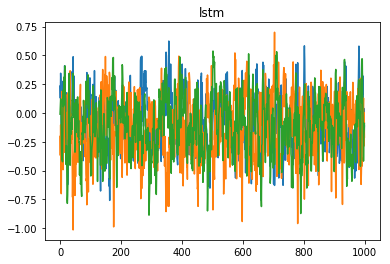

In [12]:
# test the LSTM problem class

import tigercontrol
from tigercontrol.utils.random import generate_key
import jax.numpy as np
import jax.random as random
import matplotlib.pyplot as plt


def test_lstm(steps=1000, show_plot=False, verbose=False):
    T = steps
    n, m, h = 5, 3, 10
    problem = tigercontrol.problem("LSTM-Control-v0")
    problem.initialize(n, m, h)
    assert problem.T == 0

    test_output = []
    for t in range(T):
        u = random.normal(generate_key(), shape=(n,))
        test_output.append(problem.step(u))

    info = problem.hidden()
    if verbose:
        print("hidden info:")
        print(info)
        
    assert problem.T == T
    if show_plot:
        plt.plot(test_output)
        plt.title("lstm")
        plt.show(block=False)
        plt.pause(1)
        plt.close()
    return


test_lstm(show_plot=True, verbose=True)

## PyBullet Control Problem
TigerControl supports several physics tasks from the pybullet package. The PyBulletProblem class inherits from a superclass called Simulator, and the PyBulletProblem class has a method get_simulator which returns an instance of a Simulator for the given environment. The Simulator class supports saving/loading states, getters for the observation space and action space, GUI rendering of the physics simulation, and forking to spawn a new instance of the Simulator. Below, we demonstrate how to run the KukaDiverse environment (robot arm to grasp objects) with a simple policy. 

In [0]:
"""Runs a random policy for the random object KukaDiverseObjectEnv.
"""

import tigercontrol
import numpy as np
import time
from gym import spaces


class ContinuousDownwardBiasPolicy(object):
    """Policy which takes continuous actions, and is biased to move down.
    """

    def __init__(self, height_hack_prob=0.9):
        """Initializes the DownwardBiasPolicy.

        Args:
                height_hack_prob: The probability of moving down at every move.
        """
        self._height_hack_prob = height_hack_prob
        self._action_space = spaces.Box(low=-1, high=1, shape=(5,))

    def sample_action(self, obs, explore_prob):
        """Implements height hack and grasping threshold hack.
        """
        dx, dy, dz, da, close = self._action_space.sample()
        if np.random.random() < self._height_hack_prob:
            dz = -1
        return [dx, dy, dz, da, 0.5]


def test_kuka_diverse(verbose=False):

    problem = tigercontrol.problem("KukaDiverse-v0")
    obs = problem.initialize(render=verbose)
    policy = ContinuousDownwardBiasPolicy()

    t_start = time.time()
    while time.time() - t_start < 5:
        done =  False
        episode_rew = 0
        while not done:
            if verbose:
                problem.render(mode='human')
            act = policy.sample_action(obs, .1)
            obs, rew, done, _ = problem.step(act)
            episode_rew += rew

    problem.close()
    print("test_kuka_diverse passed")


test_kuka_diverse()

Next, we demonstrate how to use getState, loadState, and fork. We will run CartPoleSwingup for 1 seconds, fork a simulator for 4 seconds, and then resume stepping through original CartPoleSwingup instance for 2 seconds from the point when the simulator was forked (i.e. t = 1).

In [0]:
"""
Test for PyBullet cartpoleSwingup problem
"""
import time
import tigercontrol
import jax.numpy as np
from tigercontrol.problems.control.pybullet.simulator import Simulator

# cartpole test
def test_simulator(verbose=False):
    problem = tigercontrol.problem("CartPoleSwingup-v0")
    obs = problem.initialize(render=verbose)

    model = tigercontrol.model("CartPoleNN")
    model.initialize(problem.get_observation_space(), problem.get_action_space())

    t_start = time.time()
    save_to_mem_ID = -1

    frame = 0
    score = 0
    restart_delay = 0
    while time.time() - t_start < 1:
        a = model.predict(obs)
        obs, r, done, _ = problem.step(a)
        score += r
        frame += 1
        if verbose:
            time.sleep(1. / 60.)

    if verbose:
        print("about to save state")
    save_to_mem_ID = problem.getState()
    if verbose:
        print("save_state_ID: " + str(save_to_mem_ID))

    # run simulator for 4 seconds
    sim = problem.fork()

    if verbose:
        print("problem.loadState worked")
    sim_score = score
    sim_frame = frame
    while time.time() - t_start < 5:
        if verbose:
            time.sleep(1. / 60.)
        a = model.predict(obs)
        obs, r, done, _ = problem.step(a)
        sim_score += r
        sim_frame += 1

    # resume stepping through problem for 2 seconds from the point when the simulator was launched (i.e. t = 1)
    problem.loadState(save_to_mem_ID)
    if verbose:
        print("problem.loadState worked")
    while time.time() - t_start < 7:
        a = model.predict(obs)
        obs, r, done, _ = problem.step(a)
        score += r
        frame += 1
        if verbose:
            time.sleep(1. / 60.)

    problem.close()
    print("test_simulator passed")


test_simulator(verbose=True)

